# Model Comparison
## This notebook compares the performance of the basis paper and the proposal on a random generated track of 100 rounds

In [1]:
import os
import gym
import gym_donkeycar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import time
import pickle
import birds_eye_vector_space
import basis_my_cv
import random
from pandas import Series, DataFrame
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
#from keras import backend as K
#import tensorflow.keras.backend as K

C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find d

In [2]:
len(tf.config.list_physical_devices('GPU'))
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 612412741237990717
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9401860096
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7945873372243034591
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:49:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6271991808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2550733652005138740
 physical_device_desc: "device: 1, name: GeForce RTX 2070 SUPER, pci bus id: 0000:21:00.0, compute capability: 7.5"
 xla_global_id: 2144165316]

In [3]:
# Supress scientific notation like: e*+03
np.set_printoptions(suppress=True)

In [4]:
ANCHOR_POINTS = 8
ROAD_ROI = np.array([(120,90),(200,90),(0,200),(320,200)],dtype='float32')
WARPED_IMAGE_SHAPE = np.array([[10,320],[0,0],[200,0],[200,310]],np.int32)            # NEW IMAGE Shape after Warping !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
WARPED_IMAGE_HEIGHT = 320
WARPED_IMAGE_WIDTH = 200
NUMBER_OF_DEPTH_LAYERS = 50

VECTOR_SPACE_IMAGE_ROWS = 50
VECTOR_SPACE_IMAGE_COLUMNS = 100
VECTOR_SPACE_IMAGE_CHANNELS = 4 # 4*(50,100) stacked frames 

In [5]:
# function to save the plots
def save_plot(data, name, episode):
    plt.figure(figsize=(8,5), frameon=True)
    #plt.plot([episode for episode in range(len(data))], data)
    plt.plot([ep for ep in range(episode)], data)
    plt.xlabel('Episodes')
    plt.ylabel(name)
    figplot = '%s-episode-%s.png' % (name,episode)
    #figplot = '{}-episode-{}.png'.format(name,episode)
    #location = '{}/saves/torch/{}'.format(os.getcwd(),figplot)
    #location = '%s/collected_data/plots/%s' % (os.getcwd(),figplot)
    location = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\evaluation\\vector\\plots\\%s' % figplot 
    plt.savefig(location, transparent=False)
    plt.close()

In [6]:
def save_data_as_dataframe(episode_number, reward, loss, measured_time, max_cte, average_cte, last_lap_time):
    episodes = [i for i in range(1, episode_number+1)]
    collected_data = {'episode': episodes, 'reward': reward, 'loss':loss, 'time': measured_time, 'max_cte': max_cte, 'average_cte': average_cte, 'lap_time': last_lap_time}
    df_data = DataFrame.from_dict(collected_data).set_index('episode')
    
    df_name = 'data-episode-%s.pkl' % episode
    #location = '%s/collected_data/raw_data/%s' % (os.getcwd(),df_name)
    location = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\evaluation\\vector\\raw_data\\%s' % df_name
    df_data.to_pickle(location)

In [7]:
vector_space = birds_eye_vector_space.Vector_space(ANCHOR_POINTS, ROAD_ROI, WARPED_IMAGE_SHAPE, WARPED_IMAGE_HEIGHT, WARPED_IMAGE_WIDTH, NUMBER_OF_DEPTH_LAYERS)

vector space is initialized
loading camera parameters


In [8]:
os.getcwd()

'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\Master-Thesis-Development-of-a-Deep-RL-Model-for-simulated-Driving-2D-Vector-Space\\docker\\src'

In [9]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        self.t = 0
        self.max_Q = 0
        self.train = True
        # Set to True to train on images with segmented lane lines
        self.lane_detection = False
        
        # Huber loss
        self.huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
        
        # Get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # CNN Input
        #self.input_shape = (VECTOR_SPACE_IMAGE_CHANNELS, VECTOR_SPACE_IMAGE_ROWS, VECTOR_SPACE_IMAGE_COLUMNS, 4)   # == 4 * (50, 100, 1); keras: (1,50,100,4)
        self.input_shape = (1, VECTOR_SPACE_IMAGE_ROWS, VECTOR_SPACE_IMAGE_COLUMNS, VECTOR_SPACE_IMAGE_CHANNELS)   # == 4 * (50, 100, 1); keras: (1,50,100,4)
        
        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 1e-4
        if (self.train):
            self.epsilon = 1.0
            self.initial_epsilon = 1.0
        else:
            self.epsilon = 1e-6
            self.initial_epsilon = 1e-6
        self.epsilon_min = 0.02
        self.batch_size = 512
        self.train_start = 100
        self.explore = 10000
        
        # Create replay memory using deque
        self.memory = deque(maxlen=10000)
        
        # Create main model and target model                # Double DQN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.model = self.build_model()
        self.target_model = self.build_model()

        # Copy the model to target model
        # --> initialize the target model so that the parameters of model & target model to be same
        self.update_target_model()

    def build_model(self):
        model = keras.Sequential([
            layers.Conv2D(filters=32, strides=(4, 4),kernel_size=8, padding='same', activation='relu', input_shape=(self.input_shape[1:])),
            layers.Conv2D(filters=64, strides=(2, 2),kernel_size=4, padding='same', activation='relu'),
            layers.Conv2D(filters=64, strides=(1, 1),kernel_size=3, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(units=512,activation='relu'),
            layers.Dense(units=512,activation='relu'),
            layers.Dense(units=15,activation='linear'),
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(loss='mse', optimizer=optimizer)
        return model
    
    def calculate_loss(self, y_true, y_pred):    
        y_pred = tf.convert_to_tensor_v2(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.reduce_mean(math_ops.square(y_pred - y_true), axis=-1)
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Get action from model using epsilon-greedy policy
    def get_action(self, s_t):
        #if np.random.rand() <= self.epsilon:
        #    #print("Return Random Value")
        #    #return random.randrange(self.action_size)
        #    return np.random.uniform(-1,1)
        #else:
        #    #print("Return Max Q Prediction")
        #    q_value = self.model.predict(s_t)
        #    # Convert q array to steering value
        #    return linear_unbin(q_value[0])
        q_value = self.model.predict(s_t)
        # Convert q array to steering value
        return linear_unbin(q_value[0])

    def replay_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        #if self.epsilon > self.epsilon_min:
        #    #self.epsilon *= self.epsilon_decay
        #    self.epsilon -= (self.initial_epsilon - self.epsilon_min) / self.explore

    def train_replay(self):
        if len(self.memory) < self.train_start:
            return
        
        # Epsilion decay over time/amount of trainings
        if self.epsilon > self.epsilon_min:
            #self.epsilon *= self.epsilon_decay
            #self.epsilon -= (self.initial_epsilon - self.epsilon_min) / self.explore
            self.epsilon -= 0.00025
            
        batch_size = min(self.batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)

        state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
        #print('Starting training\nstate_t: %s\naction_t: %s\nreward_t: %s\nstate_1: %s\nterminal: %s' % (len(state_t), len(action_t), len(reward_t), len(state_t1), len(terminal)))
        state_t = np.concatenate(state_t)
        state_t1 = np.concatenate(state_t1)
        #print('Concat:\nstate: %s\nstate_t1: %s' % (state_t, state_t1))
        targets = self.model.predict(state_t)
        self.max_Q = np.max(targets[0])
        target_val = self.model.predict(state_t1)
        target_val_ = self.target_model.predict(state_t1)
        for i in range(batch_size):
            if terminal[i]:
                targets[i][action_t[i]] = reward_t[i]
            else:
                a = np.argmax(target_val[i])
                targets[i][action_t[i]] = reward_t[i] + self.discount_factor * (target_val_[i][a])

        
        # train on the current batch and return a dictionary with the loss and so on
        #metrics = self.model.train_on_batch(x=state_t, y=targets, reset_metrics=True, return_dict=True)           
        metrics = self.model.train_on_batch(x=state_t, y=targets, reset_metrics=False, return_dict=True) #reset Metrix different
        return metrics['loss']
        
    def load_model(self, name):
        self.model.load_weights(name)

    # Save the model which is under training
    def save_model(self, name):
        self.model.save_weights(name)

In [10]:
def linear_bin(a):
    """
    Convert a value to a categorical array.

    Parameters
    ----------
    a : int or float
        A value between -1 and 1

    Returns
    -------
    list of int
        A list of length 15 with one item set to 1, which represents the linear value, and all other items set to 0.
    """
    a = a + 1
    b = round(a / (2 / 14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return arr

In [11]:
def linear_unbin(arr):
    """
    Convert a categorical array to value.

    See Also
    --------
    linear_bin
    """
    if not len(arr) == 15:
        raise ValueError('Illegal array length, must be 15')
    b = np.argmax(arr)
    a = b * (2 / 14) - 1
    return a

# Creating the environment

In [12]:
#%% SET UP ENVIRONMENT
# Normal one 
#os.environ['DONKEY_SIM_PATH'] = "/home/zamy/masterthesis/DonkeySimLinux/donkey_sim.x86_64"
os.environ['DONKEY_SIM_PATH'] = "C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\test\\DonkeySimWin\\donkey_sim.exe"
os.environ['DONKEY_SIM_PORT'] = str(9091)
os.environ['DONKEY_SIM_HEADLESS'] = str(0) # "1" is headless

CAMERA_CONF = {'cam_config':{'img_w': '320',
                        'img_h': '200',
                        'img_d': '1',   # 3 for colored Tensor image
                        'img_enc': 'PNG', 
                        'fov': '90', 
                        'fish_eye_x': '0.0', 
                        'fish_eye_y': '0.0', 
                        'offset_x': '0.0', 
                        'offset_y': '0.0', 
                        'offset_z': '0.0', 
                        'rot_x': '0'}}
# Other tracks
#env = gym.make("donkey-generated-track-v0",conf=CAMERA_CONF)

# TRACKS TRACKS - TKarmer Tracks
#env = gym.make("donkey-generated-track-v0",conf=CAMERA_CONF) #,conf=config
# Random track, but the reward is kinda not working, IF THE REWARD WORKS IT IS KINDA RANDOM !!, this maybe debends on the environment

env = gym.make("donkey-generated-roads-v0", conf=CAMERA_CONF) #,conf=config
#env = gym.make("donkey-generated-track-v0", conf=CAMERA_CONF)

# Mini Monaco Track
#env = gym.make("donkey-minimonaco-track-v0",conf=CAMERA_CONF) #,conf=config
#env = gym.make("donkey-generated-track-v0") #,conf=config
#env = gym.wrappers.ResizeObservation(env,(200,320))

INFO:gym_donkeycar.core.client:connecting to localhost:9091 
C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: port 9091
loading scene generated_road


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:done sending cam config. {'img_w': '320', 'img_h': '200', 'img_d': '1', 'img_enc': 'PNG', 'fov': '90', 'fish_eye_x': '0.0', 'fish_eye_y': '0.0', 'offset_x': '0.0', 'offset_y': '0.0', 'offset_z': '0.0', 'rot_x': '0'}


# Evaluation of the proposed model

In [13]:
# Create DQN Model
# Get size of state and action from environment
state_size = (VECTOR_SPACE_IMAGE_ROWS, VECTOR_SPACE_IMAGE_COLUMNS, VECTOR_SPACE_IMAGE_CHANNELS)
action_size = 15 # Steering and Throttle
throttle = 0.15 # Set the throttle as a constant value
agent = DQNAgent(state_size, action_size)

# loading the latest model
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_5000.h5')
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_10000.h5')
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_1400.h5')
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_5000.h5')
agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\1505model\\model_episode_4400.h5')

#first model that kinda works
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\old_model\\model_episode_5000.h5')

# Arrays for data collection / exploratory data analysis
average_cte = []
average_speed = []
measured_time = []
average_rewards = []
average_loss = []
collected_max_cte = []
collected_lap_time = []

# when a model and the data should be saved
save_state = 100

for episode in range(1,101):
    # Resetting the environment and preprocessing the first image
    observation = env.reset()
    # Graykonvertion of the observation image
    observation = cv.cvtColor(observation, cv.COLOR_BGR2GRAY)
    observation = vector_space.image_preprocessing(observation)
    # frame stacking (4 times)
    obv_stack = np.stack((observation, observation, observation, observation), axis= 2)
    # reshaping for keras
    obv_stack = obv_stack.reshape(1, obv_stack.shape[0], obv_stack.shape[1], obv_stack.shape[2])
    
    #action = np.array([0,0.10]) # drive straight with small speed
    #action = np.array([1,0.1]) # drive straight with small speed
    
    # summed up values for data collection
    # cumulative values for data collection
    total_cte = float(0)
    total_speed = float(0)
    total_reward = float(0)
    total_time = time.time()
    total_loss = float(0)
    max_cte = int(0)
    lap_time = int(0)
        
    # counting the amount of frames per episode
    frames = int(0)
    
    # boolean that describes if the env is done with this episode
    done = False
    while not done:
        # incrementing the amount of frames per episode
        frames += 1
        
        # Making a prediction for the current state
        # and getting the information form the next step
        steering = agent.get_action(obv_stack)
        action = [steering, throttle]
        next_observation, reward, done, info = env.step(action)
        # Graykonvertion of the observation image
        next_observation = cv.cvtColor(next_observation, cv.COLOR_BGR2GRAY)
        
        # printing current 'CTE'
        #print('CTE: %s' % info['cte'])
        
        # preprocessing the new observation
        next_observation_show = vector_space.image_preprocessing(next_observation)
        # reshaping for keras
        #next_observation = next_observation_show.reshape(1, next_observation_show.shape[0], next_observation_show.shape[1], 1)
        # appending to the observation stack
        #obv_stack = np.append(next_observation, obv_stack[:, :, :, :3], axis=3)
        
        obv_stack_t1 = np.stack([next_observation_show, obv_stack[0,:,:,0],obv_stack[0,:,:,1],obv_stack[0,:,:,2]], axis=2)
        obv_stack_t1 = obv_stack_t1.reshape(1, obv_stack_t1.shape[0], obv_stack_t1.shape[1], obv_stack_t1.shape[2])
                
        # saving the sample <s, a, r, s'> to the replay memory
        #agent.replay_memory(obv_stack, np.argmax(linear_bin(steering)), reward, obv_stack_t1, done)
        
        current_cte = abs(info['cte'])
        # punish and reward for a low or high 'CTE' with the logarithmic function
        if current_cte < .25:
            reward += abs(np.log(.10)) * 20
        elif current_cte >= .25 and current_cte < .5:
            reward += current_cte * 10
        elif current_cte >= .5 and current_cte < 1: 
            reward += abs(np.log(current_cte))
        elif current_cte >= 1 and current_cte < 2: 
            reward -= abs(current_cte) * 10
        elif current_cte >= 2 and current_cte < 3: 
            reward -= abs(current_cte) * 20
        elif current_cte >= 3 and current_cte < 4: 
            reward -= abs(current_cte) * 30
        elif current_cte >=4:
            reward -= abs(current_cte) * 40
                    
        # if the car leaves the track punish it
        if done:
            reward -= 250
        
        # training the DDQN, if training is enabled
        #if agent.train:
        #    loss = agent.train_replay()
        #    if loss != None:
        #        total_loss += loss
        #        #print('loss: %s ' % (total_loss / frames))
        
        # overwriting the stack and incrementing the time/frame counter
        obv_stack = obv_stack_t1
        agent.t += 1       
        
        # adding up the collected data
        current_cte = info['cte'] 
        total_cte += current_cte
        total_speed += info['speed']
        total_reward += reward
        # update if there is any change in incrementation 
        if max_cte < current_cte:
            max_cte = current_cte
        if lap_time < info['last_lap_time']:
            lap_time = info['last_lap_time']
            
        cv.imshow('vec img', next_observation_show)

        # Graykonvertion of the observation image
        #observation = cv.cvtColor(observation, cv.COLOR_BGR2GRAY)
        
        # Image preprocessing
        #vec_image = vector_space.image_preprocessing(observation)
        
        #print('REWARD: %s' % reward)
        
        #cv.imshow('vec img', vec_image)
        
        #break       # TODO: DELTE LATER
        if cv.waitKey(1) & 0xFF == ord('q'):
            cv.destroyAllWindows()
            break
    
    # Training after each episode
    #if agent.train:    
    #    total_loss = agent.train_replay()
    #    #if loss != None:
    #    #    total_loss = loss
    
    
    # AFTER this Episode & the environment returns True for the done variable
    # updating the target DDQN
    #agent.update_target_model()
    
    # calculating the average loss in this episode
    #episode_loss = total_loss.copy() #/ frames
    episode_cte = total_cte / frames
    episode_reward = total_reward / frames
    
    # updating the time parameter
    total_time = abs(total_time - time.time())
    
    # appending the collected data
    average_cte.append(episode_cte)
    average_speed.append(total_speed / frames)
    measured_time.append(total_time)
    average_rewards.append(episode_reward)
    average_loss.append(total_loss)
    collected_max_cte.append(max_cte)
    collected_lap_time.append(lap_time) 
    
    # Testing of saving the plot
    #if episode % 3 == 0 and episode != 0:
    #    save_plot(colleted_rewards, 'Reward', episode)
    #    cv.destroyAllWindows()
    #    break
    
    # Print episode information    
    print('EPISODE: %s | TIME: %s s | REWARD: %s | FRAMES: %s | QMAX: %s | EPSILON: %s | CTE: %s | LOSS: %s' % (episode, total_time, episode_reward, frames, str(agent.max_Q), agent.epsilon, episode_cte, total_loss))    
    
    if episode % save_state == 0 and episode != 0:
        print('saving after %s episodes' % save_state)
        # saving the model
        #agent.save_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_%s.h5' % episode)        
        
        # Saving the data as plots
        save_plot(average_rewards, 'Reward', episode)
        save_plot(average_cte, 'Average cte', episode)
        save_plot(collected_max_cte, 'Max cte', episode)
        save_plot(measured_time, 'Time', episode)
        save_plot(average_loss, 'Loss', episode)
        save_plot(collected_lap_time, 'Lap Time', episode)
        
        # Saving the collected data
        save_data_as_dataframe(episode, average_rewards, average_loss, measured_time, collected_max_cte, average_cte, collected_lap_time)
    
    # closing all cv windows
    cv.destroyAllWindows()

# closing all cv windows
cv.destroyAllWindows()
# Close the enviroment
#env.close()

EPISODE: 1 | TIME: 213.8093066215515 s | REWARD: 31.612679891012785 | FRAMES: 2185 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.08333253658446221 | LOSS: 0.0
EPISODE: 2 | TIME: 201.406555891037 s | REWARD: 37.28881273968463 | FRAMES: 2096 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.10532429997626405 | LOSS: 0.0
EPISODE: 3 | TIME: 212.39740920066833 s | REWARD: 38.05626424723552 | FRAMES: 2207 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.03139754897148172 | LOSS: 0.0
EPISODE: 4 | TIME: 212.63121461868286 s | REWARD: 40.26643463126519 | FRAMES: 2211 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.013740687138986903 | LOSS: 0.0
EPISODE: 5 | TIME: 209.9484465122223 s | REWARD: 35.39384067825031 | FRAMES: 2183 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.1354357983561476 | LOSS: 0.0
EPISODE: 6 | TIME: 200.4037308692932 s | REWARD: 39.39656500531524 | FRAMES: 2083 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.02086659716005281 | LOSS: 0.0
EPISODE: 7 | TIME: 201.53051280975342 s | REWARD: 37.97156042046259 | FRAMES: 2076 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.030

EPISODE: 57 | TIME: 212.8436779975891 s | REWARD: 27.179920309309075 | FRAMES: 2202 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.17571975897815623 | LOSS: 0.0
EPISODE: 58 | TIME: 210.7521529197693 s | REWARD: 36.967522822594084 | FRAMES: 2185 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.13578482763470018 | LOSS: 0.0
EPISODE: 59 | TIME: 209.78690910339355 s | REWARD: 27.76068595565304 | FRAMES: 2172 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.17023808770980198 | LOSS: 0.0
EPISODE: 60 | TIME: 202.30465650558472 s | REWARD: 39.233367734845054 | FRAMES: 2096 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.010903218020944643 | LOSS: 0.0
EPISODE: 61 | TIME: 199.98142170906067 s | REWARD: 37.53758562833232 | FRAMES: 2072 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.0250109732083012 | LOSS: 0.0
EPISODE: 62 | TIME: 200.37265133857727 s | REWARD: 38.28850089858713 | FRAMES: 2074 | QMAX: 0 | EPSILON: 1.0 | CTE: 0.028867825596620017 | LOSS: 0.0
EPISODE: 63 | TIME: 208.88812589645386 s | REWARD: 37.2405754840053 | FRAMES: 2165 | QMAX: 0 | EPSILON: 1.0 

# Evaluation of the basis model

In [15]:
# function to save the plots
def save_plot(data, name, episode):
    plt.figure(figsize=(8,5), frameon=True)
    #plt.plot([episode for episode in range(len(data))], data)
    plt.plot([ep for ep in range(episode)], data)
    plt.xlabel('Episodes')
    plt.ylabel(name)
    figplot = '%s-episode-%s.png' % (name,episode)
    #figplot = '{}-episode-{}.png'.format(name,episode)
    #location = '{}/saves/torch/{}'.format(os.getcwd(),figplot)
    #location = '%s/collected_data/plots/%s' % (os.getcwd(),figplot)
    location = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\evaluation\\basis\\plots\\%s' % figplot 
    plt.savefig(location, transparent=False)
    plt.close()

In [16]:
def save_data_as_dataframe(episode_number, reward, loss, measured_time, max_cte, average_cte, last_lap_time):
    episodes = [i for i in range(1, episode_number+1)]
    collected_data = {'episode': episodes, 'reward': reward, 'loss':loss, 'time': measured_time, 'max_cte': max_cte, 'average_cte': average_cte, 'lap_time': last_lap_time}
    df_data = DataFrame.from_dict(collected_data).set_index('episode')
    
    df_name = 'data-episode-%s.pkl' % episode
    #location = '%s/collected_data/raw_data/%s' % (os.getcwd(),df_name)
    location = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\evaluation\\basis\\raw_data\\%s' % df_name
    df_data.to_pickle(location)

In [17]:
def process_image(obs):
    #obs = cv.cvtColor(obs, cv.COLOR_BGR2GRAY)
    obs = cv.resize(obs, (VECTOR_SPACE_IMAGE_ROWS, VECTOR_SPACE_IMAGE_COLUMNS))
    edges = basis_my_cv.detect_edges(obs, low_threshold=50, high_threshold=150)
    rho = 0.8
    theta = np.pi/180
    threshold = 25
    min_line_len = 5
    max_line_gap = 10
    hough_lines = basis_my_cv.hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
    left_lines, right_lines = basis_my_cv.separate_lines(hough_lines)
    filtered_right, filtered_left = [],[]
    if len(left_lines):
        filtered_left = basis_my_cv.reject_outliers(left_lines, cutoff=(-30.0, -0.1), lane='left')
    if len(right_lines):
        filtered_right = basis_my_cv.reject_outliers(right_lines,  cutoff=(0.1, 30.0), lane='right')
    lines = []
    if len(filtered_left) and len(filtered_right):
        lines = np.expand_dims(np.vstack((np.array(filtered_left),np.array(filtered_right))),axis=0).tolist()
    elif len(filtered_left):
        lines = np.expand_dims(np.expand_dims(np.array(filtered_left),axis=0),axis=0).tolist()
    elif len(filtered_right):
        lines = np.expand_dims(np.expand_dims(np.array(filtered_right),axis=0),axis=0).tolist()
    ret_img = np.zeros((80,80))
    if len(lines):
        try:
            basis_my_cv.draw_lines(ret_img, lines, thickness=1)
        except:
            pass
    return ret_img

In [18]:
# Hyperparemters for the basis models
ANCHOR_POINTS = 8
ROAD_ROI = np.array([(120,90),(200,90),(0,200),(320,200)],dtype='float32')
WARPED_IMAGE_SHAPE = np.array([[10,320],[0,0],[200,0],[200,310]],np.int32)            # NEW IMAGE Shape after Warping !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
WARPED_IMAGE_HEIGHT = 320
WARPED_IMAGE_WIDTH = 200
NUMBER_OF_DEPTH_LAYERS = 50

VECTOR_SPACE_IMAGE_ROWS = 80
VECTOR_SPACE_IMAGE_COLUMNS = 80
VECTOR_SPACE_IMAGE_CHANNELS = 4 # 4*(50,100) stacked frames

In [19]:
# Create DQN Model
# Get size of state and action from environment
state_size = (VECTOR_SPACE_IMAGE_ROWS, VECTOR_SPACE_IMAGE_COLUMNS, VECTOR_SPACE_IMAGE_CHANNELS)
action_size = 15 # Steering and Throttle
throttle = 0.15 # Set the throttle as a constant value
agent = DQNAgent(state_size, action_size)

# loading the latest model
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_5000.h5')
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_10000.h5')
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_1400.h5')
agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\2305basis\\model_episode_5000.h5')

#first model that kinda works
#agent.load_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\old_model\\model_episode_5000.h5')

# Arrays for data collection / exploratory data analysis
average_cte = []
average_speed = []
measured_time = []
average_rewards = []
average_loss = []
collected_max_cte = []
collected_lap_time = []

# when a model and the data should be saved
save_state = 100

for episode in range(1,101):
    # Resetting the environment and preprocessing the first image
    observation = env.reset()
    # Graykonvertion of the observation image
    #observation = cv.cvtColor(observation, cv.COLOR_BGR2GRAY)
    #observation = vector_space.image_preprocessing(observation)
    observation = process_image(observation)
    # frame stacking (4 times)
    obv_stack = np.stack((observation, observation, observation, observation), axis= 2)
    # reshaping for keras
    obv_stack = obv_stack.reshape(1, obv_stack.shape[0], obv_stack.shape[1], obv_stack.shape[2])
    
    #action = np.array([0,0.10]) # drive straight with small speed
    #action = np.array([1,0.1]) # drive straight with small speed
    
    # summed up values for data collection
    # cumulative values for data collection
    total_cte = float(0)
    total_speed = float(0)
    total_reward = float(0)
    total_time = time.time()
    total_loss = float(0)
    max_cte = int(0)
    lap_time = int(0)
        
    # counting the amount of frames per episode
    frames = int(0)
    
    # boolean that describes if the env is done with this episode
    done = False
    while not done:
        # incrementing the amount of frames per episode
        frames += 1
        
        # Making a prediction for the current state
        # and getting the information form the next step
        steering = agent.get_action(obv_stack)
        action = [steering, throttle]
        next_observation, reward, done, info = env.step(action)
        # Graykonvertion of the observation image
        next_observation = cv.cvtColor(next_observation, cv.COLOR_BGR2GRAY)
        
        # printing current 'CTE'
        #print('CTE: %s' % info['cte'])
        
        # preprocessing the new observation
        #next_observation_show = vector_space.image_preprocessing(next_observation)
        next_observation_show = process_image(next_observation)
        # reshaping for keras
        #next_observation = next_observation_show.reshape(1, next_observation_show.shape[0], next_observation_show.shape[1], 1)
        # appending to the observation stack
        #obv_stack = np.append(next_observation, obv_stack[:, :, :, :3], axis=3)
        
        obv_stack_t1 = np.stack([next_observation_show, obv_stack[0,:,:,0],obv_stack[0,:,:,1],obv_stack[0,:,:,2]], axis=2)
        obv_stack_t1 = obv_stack_t1.reshape(1, obv_stack_t1.shape[0], obv_stack_t1.shape[1], obv_stack_t1.shape[2])
                
        # saving the sample <s, a, r, s'> to the replay memory
        #agent.replay_memory(obv_stack, np.argmax(linear_bin(steering)), reward, obv_stack_t1, done)
        
        current_cte = abs(info['cte'])
        # punish and reward for a low or high 'CTE' with the logarithmic function
        if current_cte < .25:
            reward += abs(np.log(.10)) * 20
        elif current_cte >= .25 and current_cte < .5:
            reward += current_cte * 10
        elif current_cte >= .5 and current_cte < 1: 
            reward += abs(np.log(current_cte))
        elif current_cte >= 1 and current_cte < 2: 
            reward -= abs(current_cte) * 10
        elif current_cte >= 2 and current_cte < 3: 
            reward -= abs(current_cte) * 20
        elif current_cte >= 3 and current_cte < 4: 
            reward -= abs(current_cte) * 30
        elif current_cte >=4:
            reward -= abs(current_cte) * 40
                    
        # if the car leaves the track punish it
        if done:
            reward -= 250
        
        # training the DDQN, if training is enabled
        #if agent.train:
        #    loss = agent.train_replay()
        #    if loss != None:
        #        total_loss += loss
        #        #print('loss: %s ' % (total_loss / frames))
        
        # overwriting the stack and incrementing the time/frame counter
        obv_stack = obv_stack_t1
        agent.t += 1       
        
        # adding up the collected data
        current_cte = info['cte'] 
        total_cte += current_cte
        total_speed += info['speed']
        total_reward += reward
        # update if there is any change in incrementation 
        if max_cte < current_cte:
            max_cte = current_cte
        if lap_time < info['last_lap_time']:
            lap_time = info['last_lap_time']
            
        cv.imshow('vec img', next_observation_show)

        # Graykonvertion of the observation image
        #observation = cv.cvtColor(observation, cv.COLOR_BGR2GRAY)
        
        # Image preprocessing
        #vec_image = vector_space.image_preprocessing(observation)
        
        #print('REWARD: %s' % reward)
        
        #cv.imshow('vec img', vec_image)
        
        #break       # TODO: DELTE LATER
        if cv.waitKey(1) & 0xFF == ord('q'):
            cv.destroyAllWindows()
            break
    
    # Training after each episode
    #if agent.train:    
    #    total_loss = agent.train_replay()
    #    #if loss != None:
    #    #    total_loss = loss
    
    
    # AFTER this Episode & the environment returns True for the done variable
    # updating the target DDQN
    #agent.update_target_model()
    
    # calculating the average loss in this episode
    #episode_loss = total_loss.copy() #/ frames
    episode_cte = total_cte / frames
    episode_reward = total_reward / frames
    
    # updating the time parameter
    total_time = abs(total_time - time.time())
    
    # appending the collected data
    average_cte.append(episode_cte)
    average_speed.append(total_speed / frames)
    measured_time.append(total_time)
    average_rewards.append(episode_reward)
    average_loss.append(total_loss)
    collected_max_cte.append(max_cte)
    collected_lap_time.append(lap_time) 
    
    # Testing of saving the plot
    #if episode % 3 == 0 and episode != 0:
    #    save_plot(colleted_rewards, 'Reward', episode)
    #    cv.destroyAllWindows()
    #    break
    
    # Print episode information    
    print('EPISODE: %s | TIME: %s s | REWARD: %s | FRAMES: %s | QMAX: %s | EPSILON: %s | CTE: %s | LOSS: %s' % (episode, total_time, episode_reward, frames, str(agent.max_Q), agent.epsilon, episode_cte, total_loss))    
    
    if episode % save_state == 0 and episode != 0:
        print('saving after %s episodes' % save_state)
        # saving the model
        #agent.save_model('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\models\\model_episode_%s.h5' % episode)        
        
        # Saving the data as plots
        save_plot(average_rewards, 'Reward', episode)
        save_plot(average_cte, 'Average cte', episode)
        save_plot(collected_max_cte, 'Max cte', episode)
        save_plot(measured_time, 'Time', episode)
        save_plot(average_loss, 'Loss', episode)
        save_plot(collected_lap_time, 'Lap Time', episode)
        
        # Saving the collected data
        save_data_as_dataframe(episode, average_rewards, average_loss, measured_time, collected_max_cte, average_cte, collected_lap_time)
    
    # closing all cv windows
    cv.destroyAllWindows()

# closing all cv windows
cv.destroyAllWindows()
# Close the enviroment
env.close()

C:\Users\studwilksa2535\Desktop\DonkeyCarAI\Master-Thesis-Development-of-a-Deep-RL-Model-for-simulated-Driving-2D-Vector-Space\docker\src\basis_my_cv.py:30: RuntimeWarning: divide by zero encountered in int_scalars
  return (y1 - y2) / (x1 - x2)


EPISODE: 1 | TIME: 209.44566440582275 s | REWARD: 18.128679423518985 | FRAMES: 2192 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.39755590308220745 | LOSS: 0.0
EPISODE: 2 | TIME: 219.849609375 s | REWARD: -100.1344237658994 | FRAMES: 2307 | QMAX: 0 | EPSILON: 1.0 | CTE: -2.857356342619082 | LOSS: 0.0
EPISODE: 3 | TIME: 195.44680166244507 s | REWARD: 17.596273071754528 | FRAMES: 2052 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.3882497060006129 | LOSS: 0.0
EPISODE: 4 | TIME: 201.80632877349854 s | REWARD: 13.64908040784005 | FRAMES: 2121 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.4884410144061294 | LOSS: 0.0
EPISODE: 5 | TIME: 78.88468265533447 s | REWARD: -27.64429987074931 | FRAMES: 826 | QMAX: 0 | EPSILON: 1.0 | CTE: -1.3531146717636946 | LOSS: 0.0
EPISODE: 6 | TIME: 105.26036190986633 s | REWARD: -54.77265730628759 | FRAMES: 1105 | QMAX: 0 | EPSILON: 1.0 | CTE: -1.938749102630498 | LOSS: 0.0
EPISODE: 7 | TIME: 88.46445107460022 s | REWARD: -34.72979100633383 | FRAMES: 930 | QMAX: 0 | EPSILON: 1.0 | CTE: -1.4887

EPISODE: 57 | TIME: 209.87357783317566 s | REWARD: 7.123721691070857 | FRAMES: 2220 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.6100326943534234 | LOSS: 0.0
EPISODE: 58 | TIME: 201.43524718284607 s | REWARD: -108.92608338303917 | FRAMES: 2125 | QMAX: 0 | EPSILON: 1.0 | CTE: -3.074109292621926 | LOSS: 0.0
EPISODE: 59 | TIME: 209.2927885055542 s | REWARD: 16.578510586215028 | FRAMES: 2211 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.3615369013908507 | LOSS: 0.0
EPISODE: 60 | TIME: 207.82506895065308 s | REWARD: 8.222152640952862 | FRAMES: 2197 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.5783687616884389 | LOSS: 0.0
EPISODE: 61 | TIME: 197.6294665336609 s | REWARD: 17.025546998123744 | FRAMES: 2088 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.35633263612543176 | LOSS: 0.0
EPISODE: 62 | TIME: 208.5150899887085 s | REWARD: 9.69406108305658 | FRAMES: 2200 | QMAX: 0 | EPSILON: 1.0 | CTE: -0.5732629772312278 | LOSS: 0.0
EPISODE: 63 | TIME: 209.53511762619019 s | REWARD: 8.687531033927382 | FRAMES: 2215 | QMAX: 0 | EPSILON: 1.0 | C

# EDA - Look into the collected data

In [20]:
path_evaluation = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\evaluation\\'

## Vector space data

In [21]:
vector_data = pd.read_pickle(path_evaluation + '%s' % '\\vector\\raw_data\\data-episode-100.pkl')

In [22]:
vector_data.head()

,reward,loss,time,max_cte,average_cte,lap_time
episode,,,,,,
1,31.612680,0.0,213.809307,1.425918,-0.083333,0
2,37.288813,0.0,201.406556,3.552470,0.105324,0
3,38.056264,0.0,212.397409,1.073205,0.031398,0
4,40.266435,0.0,212.631215,1.193110,0.013741,0
5,35.393841,0.0,209.948447,3.472174,0.135436,0


In [23]:
vector_data.describe().T

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1558: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


,count,mean,std,min,25%,50%,75%,max
reward,100.0,18.995967,40.411633,-121.136491,28.805095,37.749369,38.900824,42.805750
loss,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
time,100.0,197.641744,31.102828,25.115170,199.735846,202.309575,211.369199,216.383807
max_cte,100.0,1.500033,0.886105,0.273381,1.003127,1.263682,1.650136,5.034770
average_cte,100.0,-0.430718,0.944517,-3.677833,-0.201951,0.004082,0.025027,0.194137
lap_time,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
# Mean of the reward
print('Reward: %s' % vector_data['reward'].mean())
print('Time: %s' % vector_data['time'].mean())
print('CTE: %s' % vector_data['average_cte'].mean())

Reward: 18.99596689354035
Time: 197.64174431800842
CTE: -0.43071790607353017


## Basis data

In [26]:
basis_data = pd.read_pickle(path_evaluation + '%s' % '\\basis\\raw_data\\data-episode-100.pkl')

In [27]:
basis_data.describe().T

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1558: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


,count,mean,std,min,25%,50%,75%,max
reward,100.0,-1.732122,35.006059,-111.610235,7.148558,10.483665,17.029305,19.085412
loss,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
time,100.0,189.051903,38.183619,61.275017,195.429923,198.786493,208.065512,219.849609
max_cte,100.0,0.806596,1.319162,0.017317,0.217754,0.360434,0.598081,5.288000
average_cte,100.0,-0.791944,0.743420,-3.121726,-0.603085,-0.528895,-0.393759,-0.332204
lap_time,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
# Mean of the reward
print('Reward: %s' % basis_data['reward'].mean())
print('Time: %s' % basis_data['time'].mean())
print('CTE: %s' % basis_data['average_cte'].mean())

Reward: -1.7321215904532772
Time: 189.05190251350402
CTE: -0.7919442009954727


## First insights
Important Information:
- CTE: Closer to Zero is better
- Reward: Higher is better

The comparision of the average reward & CTE shows some significant differences.
The Vector Space model achieves a lower CTE and higher reward on the the test bench.
The Basis model has a higher CTE and lower reward.

Therefore, from the quantitaive data, it can be conlcuded that the Vector Space model is better than the basis model

## Visiual plots for comparison

### Reward comparision

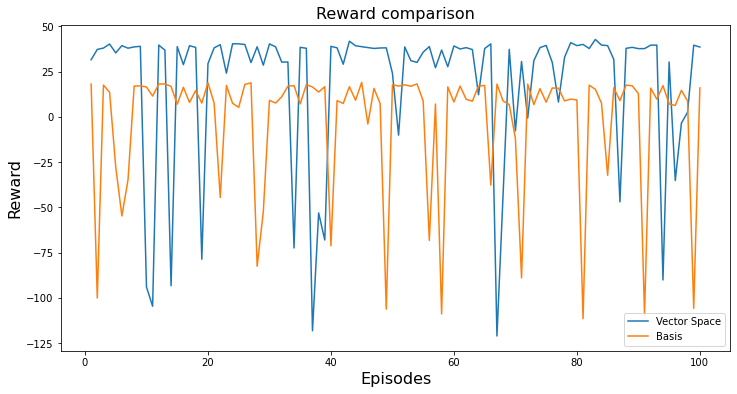

In [42]:
plt.figure(figsize=(12,6))
plt.title('Reward comparison', fontsize=16)
plt.plot(vector_data.index, vector_data['reward'], label='Vector Space')
plt.plot(basis_data.index, basis_data['reward'], label='Basis')
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.legend(loc="lower right")
plt.show()

### CTE comparison

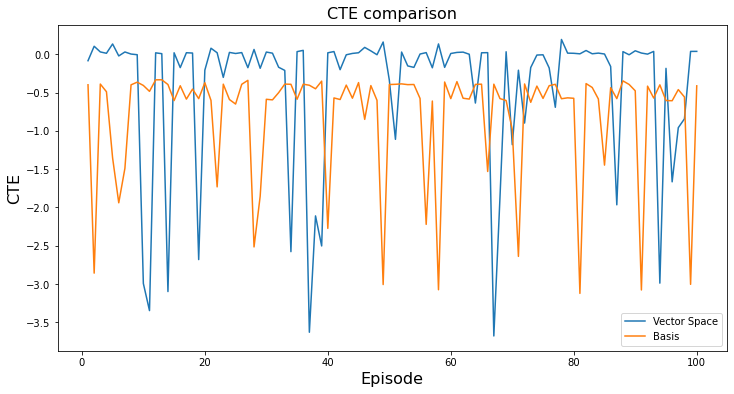

In [45]:
plt.figure(figsize=(12,6))
plt.title('CTE comparison', fontsize=16)
plt.plot(vector_data.index, vector_data['average_cte'], label='Vector Space')
plt.plot(basis_data.index, basis_data['average_cte'], label='Basis')
plt.xlabel('Episode', fontsize=16)
plt.ylabel('CTE', fontsize=16)
plt.legend(loc="lower right")
plt.show()